<a href="https://www.kaggle.com/code/mousavin0/titanic-dataset-classification-models?scriptVersionId=117183641" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')

# Data Exploration

In [2]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

Both the training and test datasets contain missing values. Age, Cabin, Embarked, and Fare have missing values. We won't use Cabin, but we'll fill in the others using group means and modes.

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The above summary shows that the minimum fare value is 0 and the maximum value is very high.

In [4]:
display(train.loc[train['Fare']==0]['Ticket'].value_counts())

LINE      4
239853    3
112059    1
239854    1
112052    1
239856    1
239855    1
112050    1
112058    1
19972     1
Name: Ticket, dtype: int64

In [5]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [6]:
train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In the above results, we can see that the Ticket variable contains duplicates. Fare can correspond to group tickets, which may explain its high value.

In [7]:
train.loc[(train['Parch']==0) & (train['SibSp']==0)]['Ticket'].value_counts()

1601        7
LINE        4
239853      3
PC 17760    3
110152      3
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 502, dtype: int64

In [8]:
train[train['Ticket']=='1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


This group has the same ticket number SibSp=0 and Parch=0. This shows that not all group tickets belong to relatives (parents, children, stepchildren, siblings, stepbrothers, stepsisters, spouses). 

In [9]:
train.groupby('Ticket')['Fare'].nunique().sort_values()

Ticket
110152       1
368323       1
36864        1
36865        1
36866        1
            ..
28664        1
28665        1
28213        1
WE/P 5735    1
7534         2
Name: Fare, Length: 681, dtype: int64

In [10]:
train[train['Ticket']=='7534']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
138,139,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S


There is only one duplicate ticket with unidentical Fare values. In order to get the fare per passenger, we would need information about all passengers to know how many are in each ticket. To do this, we'll need to use test data (which we skip; we use Fare as it is). 


# Data preprocessing - Data Visualization - Feature Engineering

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The name column contains first name, title, and last name. For the Title, we add a new column.

In [12]:
train['Title'], test['Title'] = [df.Name.str.extract \
        (' ([A-Za-z]+)\.', expand=False) for df in [train, test]]

In [13]:
display(train['Title'].value_counts())
display(test['Title'].value_counts())
display([x for x in test['Title'].unique() if x not in train['Title'].unique()] )

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

['Dona']

Titles need to be categorised into fewer categories.

In [14]:
new_title={"Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
             "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
             "Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
             "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty", "Dona" : "Royalty"}

train['Title'], test['Title'] = [df.Title.map(new_title) for df in [train, test]]
display(train['Title'].value_counts())
display(test['Title'].value_counts())

Mr         517
Miss       184
Mrs        127
Master      40
Royalty     18
Officer      5
Name: Title, dtype: int64

Mr         240
Miss        78
Mrs         73
Master      21
Royalty      4
Officer      2
Name: Title, dtype: int64

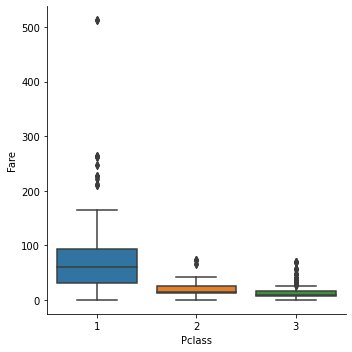

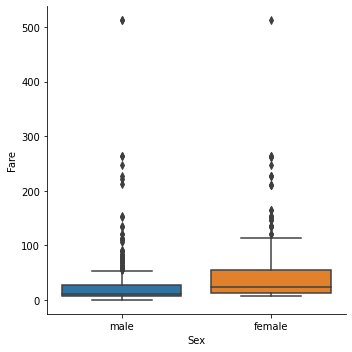

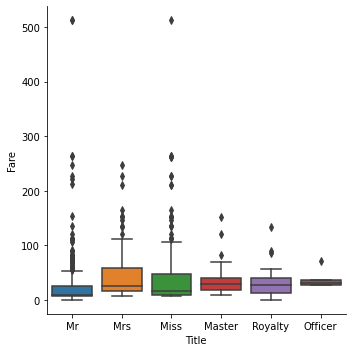

In [15]:
import seaborn as sns
sns.catplot(data=train, x="Pclass", y="Fare", kind="box")
sns.catplot(data=train, x="Sex", y="Fare", kind="box")
sns.catplot(data=train, x="Title", y="Fare", kind="box")

We now look closer at some variables with null values.

In [16]:
train[train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


Both individuals belong to Pclass=1.

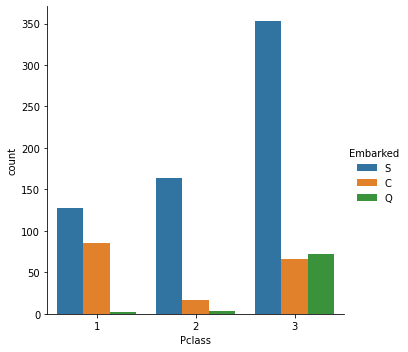

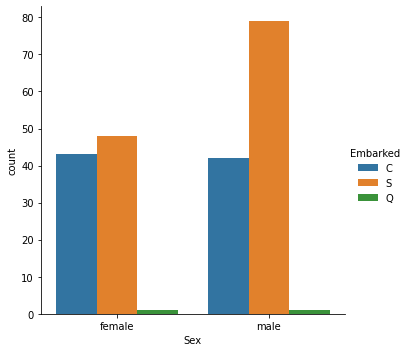

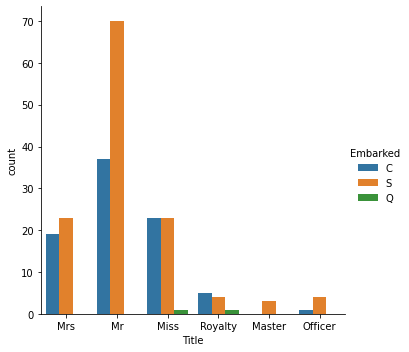

In [17]:
sns.catplot(data=train, x="Pclass", kind="count", hue="Embarked")
sns.catplot(data=train[train['Pclass']==1], x="Sex", kind="count", hue="Embarked")
sns.catplot(data=train[train['Pclass']==1], x="Title", hue="Embarked",kind='count')


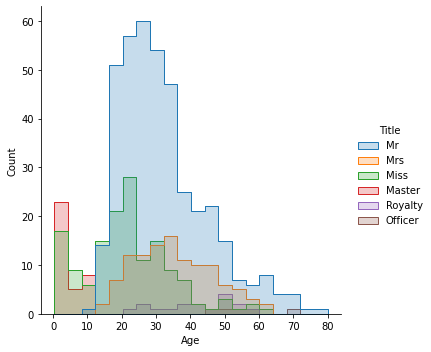

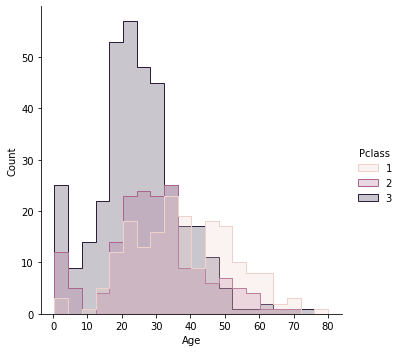

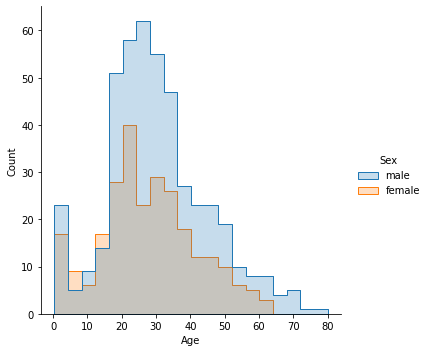

In [18]:
sns.displot(data=train, x="Age", hue="Title",element='step')
sns.displot(data=train, x="Age", hue="Pclass",element='step')
sns.displot(data=train, x="Age", hue="Sex",element='step')

We can use mean/median to fill in the null values. Our goal is to do better than sample means by using group means, i.e., groups are formed based on three categorical variables:

In [19]:
groups= train.groupby(['Title','Sex','Pclass'])['Age'].agg(['mean','count'])

The following is the function we use for filling null values.

In [20]:
def fill_y(train,test,y,group_by_list,agg):
    groups= train.groupby(group_by_list)[y].agg(agg)
    temp=[]
    for index, x in train[train[y].isna()].iterrows():
        temp.append(groups.loc[tuple(x.loc[group_by_list])])    
    train.loc[train[y].isna(),y]=temp  
    temp=[]
    for index, x in test[test[y].isna()].iterrows():
        temp.append(groups.loc[tuple(x.loc[group_by_list])])    
    test.loc[test[y].isna(),y]=temp  
    


In [21]:
fill_y(train,test,'Age',['Title','Sex','Pclass'],'mean')
fill_y(train,test,'Fare',['Title','Sex','Pclass'],'mean')
#take the first mode if there are several
fill_y(train,test,'Embarked',['Title','Sex','Pclass'],lambda x: pd.Series.mode(x)[0])

It is important to make sure all null values are filled because some missing values that do not belong to any of the groups could still be null values.

In [22]:
display(train.isna().sum())
display(test.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Title            0
dtype: int64

Before fitting classification models, we have to make dummy variables from categorical ones. 

In [23]:
train=pd.get_dummies(train, columns=['Pclass','Sex','Embarked','Title'], drop_first=True)
test=pd.get_dummies(test, columns=['Pclass','Sex','Embarked','Title'], drop_first=True)
X_train=train.drop(columns=['PassengerId','Survived','Name','Ticket','Cabin'])
y_train=train['Survived']
X_test=test.drop(columns=['Name','Ticket','Cabin'])

In [24]:
X_train.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,1,0,7.2500,0,1,1,0,1,0,1,0,0,0
1,38.0,1,0,71.2833,0,0,0,0,0,0,0,1,0,0
2,26.0,0,0,7.9250,0,1,0,0,1,1,0,0,0,0
3,35.0,1,0,53.1000,0,0,0,0,1,0,0,1,0,0
4,35.0,0,0,8.0500,0,1,1,0,1,0,1,0,0,0


We treat the first 4 columns as numerical values. Linear models might perform better if we use them as categorical variables (categorical variables can be constructed using *pd.cut*).

# Classification: Hyper parameter tuning using GridSearchCV - Feature Scaling inside Piplines - Logistic regression/SVM/SGD/KNN/Decision Tree/Gradient Boosting/Random Forest/Naive Bayes

The following function will be used for hyperparameter tuning. It returns the mean cross validation score of the best estimator and the best estimator fit.

In [25]:
from sklearn.model_selection import GridSearchCV
def grid_search_result(estimator,param_grid,X,y,cv=5):
    gscv = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv)
    #return gscv
    gscv.fit(X, y)
    return gscv.best_score_, gscv.best_estimator_
    

We begin by linear logistic model with lasso penalty term. 

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

logisticRegr = LogisticRegression(penalty='l1', solver='liblinear',random_state=0)
#smaller C bigger regularization
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10]}
logisticRegr_mean_cross_val_score_best_model, logisticRegr_best_model =grid_search_result(logisticRegr,param_grid,X_train,y_train)
logisticRegr_mean_cross_val_score_best_model



0.828278199736363

By using nonlinear transformation of the features in logistic regression we can avoid linearity assumption. Support vector machines work more efficiently with nonlinear kernels. That is because it uses the hinge function as the loss function; which implies that only a subset of data (support vectors) contribute to the loss. Support vectors are those observations that are classified incorrectly or are close to the decision boundary. Another intuition for SVM is that it maximises the margin (distance between data points and decision boundary). 

In [27]:
from sklearn.svm import SVC
svm = SVC(random_state=0)
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
svm_mean_cross_val_score_best_model, svm_best_model =grid_search_result(svm,param_grid,X_train,y_train)
svm_mean_cross_val_score_best_model


0.7901512773837173

SGD implements linear models using different loss functions and it performs minimization by stochastic gradient descent. We expect that it performs similarly to logistic regression when loss is 'log_loss' and similarly to SVM when loss is 'hinge'.

In [28]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=0)
#alpha is inverse of C
param_grid = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
           }
#,'log_loss'
sgd_mean_cross_val_score_best_model, sgd_best_model =grid_search_result(sgd,param_grid,X_train,y_train)
sgd_mean_cross_val_score_best_model


0.7487414474923106

For KNN we use a pipeline to standardize two of the numerical data; age and fare.

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
#param_grid = dict(n_neighbors=k_range)
#knn_mean_cross_val_score_best_model, knn_best_model =grid_search_result(knn,param_grid,X_train,y_train)


numeric_features = ['Age','Fare']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', knn)])




param_grid = {'classifier__n_neighbors':k_range}
knn_mean_cross_val_score_best_model, knn_best_model =grid_search_result(clf,param_grid,X_train,y_train)





knn_mean_cross_val_score_best_model


0.7004080095411462

We now use some tree-based models. They do not assume linearity and do not need feature scaling. A decision tree (CART stands for classification and regression tree) decides about node splits based on one criteria; maximising the information gain. Information gain from a specific split is the information in a parent node minus the weighted mean of the information in its children nodes. In case of a classification problem the information function can be gini or entropy and in a regression problem it can be MSE of a node. MSE of a node is mean squared of labels of data that belong to a node minus their predicted values; in case of regression the predictions are found by taking the mean of the labels of the data that belong to a node.

In [30]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)

param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
dt_mean_cross_val_score_best_model, dt_best_model =grid_search_result(dt,param_grid,X_train,y_train)
dt_mean_cross_val_score_best_model


0.8271420500910175

To avoid high variance of a single model, we can use ensemble models. Bagging, for example, uses bootstrap samples of the same size as the original sample and take the average or vote from their model fits. Since not all observations are included in each of the bootstrap sample (out of bag instances) they can be used to find the error of each of the model. The accuracy can then be found using the average of the accuracy on the out of bag samples for each bootstrap sample (model.oob_score_). This could be helpful in avoiding cross validation. However since we are using GridSearchCV to tune the hyperparameters the cross validation accuracy is available.

Random forest works similarly. It has always decision tree as the base learner. It has an extra randomness for each of the models fit on the bootstrap samples; meaning that for each sample it only uses a $d$ number of randomly choosen features.

The idea of boosting, on the other hand, is to train an ensemble of models sequentially where each one tries to correct the previous. Most popular ones are AdaBoost and Gradient Boosting. Boosting combines multiple weak learners (Decision stump = CART with max depth = 1)

In [31]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
grd = GradientBoostingClassifier(random_state=0)

param_grid = {
    "learning_rate": [0.05, 0.1],
 #   "min_samples_split": np.linspace(0.1, 0.5, 2),
 #   "min_samples_leaf": np.linspace(0.1, 0.5, 2),
    "max_depth":[3,5,8],
 #   "max_features":["log2","sqrt"],
    "n_estimators":[10,100]
    }

grd_mean_cross_val_score_best_model, grd_best_model =grid_search_result(grd,param_grid,X_train,y_train)
grd_mean_cross_val_score_best_model


0.8294080723118448

In [32]:
#Random Forest Classifier
rand = RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [10, 200],
 #   'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8],
  #  'criterion' :['gini', 'entropy']
}


rand_mean_cross_val_score_best_model, rand_best_model =grid_search_result(rand,param_grid,X_train,y_train)
rand_mean_cross_val_score_best_model


0.8282656455966354

Naive bayes is a fast and scalable classifier which uses Bayes formula to find posterior probabilities and choose a classifier that minimises the probabilities of missclassification of maximises posterior probability. 
$$P(H|feat) = \frac {P(feat|H)P(H)}{P(feat)}$$
The naive bayes is called naive because it assumes that features are independent of each other given the hypothesis $H$ (for any give class). The term in the denominator does not need to be calculated because it is enough to find the numerator for all hypothesis and choose the one with the biggest value of the numerator (which would be the one with the biggest probability). In other words,
$$P(H|feat) \propto  {P(feat_1|H)\cdots P(feat_p|H)P(H)} $$

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
gnb = GaussianNB()

scores_gnb = cross_val_score(gnb, X_train, y_train, cv = 8)
print(scores_gnb.mean(), scores_gnb.std())

0.7855936293436293 0.02472660904449041


In [34]:
output = output = pd.DataFrame({
"PassengerId": X_test["PassengerId"],
"Survived": grd_best_model.predict(X_test.drop(columns=['PassengerId']))
})

output.to_csv('submission.csv',index=False)